In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Layout
import numpy as np
import starry

In [3]:
warning_message = lambda message: print('[WARNING] {}'.format(message))

In [22]:
min(1, np.sqrt(3)/a-3, 5),np.sqrt(3)/a-3, 5

(-4.440892098500626e-16, -4.440892098500626e-16, 5)

/home/acc/anaconda3/envs/baseclone/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in double_scalars
/home/acc/anaconda3/envs/baseclone/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


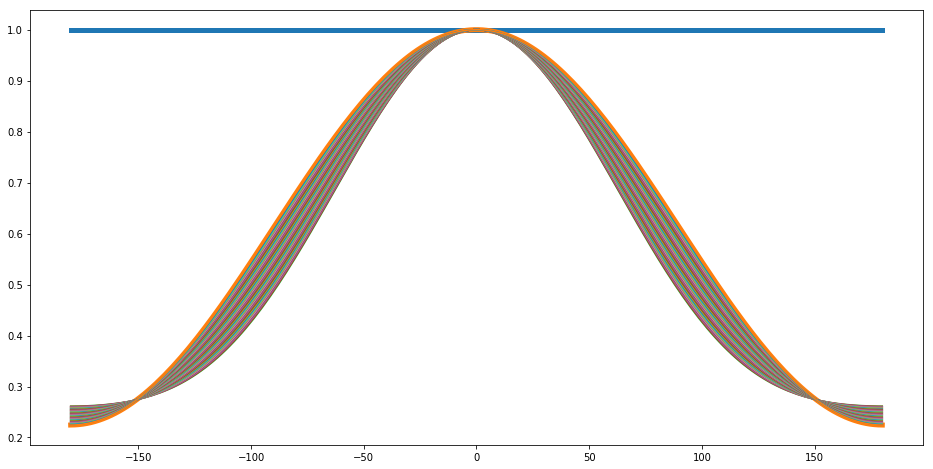

In [44]:
#                                                                               |
def starry_physical_map(longitude, a=0.3, b=0.0, 
                        latitude_model = None, lmax = 3, 
                        planet_map = None):
    
    if planet_map is None: 
        planet_map = starry.Map(lmax)
        planet_map[0, 0] = 1.0
    
    # Check if physical
    if b > np.sqrt(3) / a - 3: 
        warning_message('Negative night flux encountered')
    
    """Interactive visualization."""
    # Set the coeffs
    planet_map[1, 0] = a
    planet_map[2, 0] = -a * b / np.sqrt(15)
    
    if latitude_model is None:
        latitude = np.linspace(-90, 90, len(longitude))
        y = np.sin(latitude * np.pi / 180.)
    else:
        y = latitude_model
    
    # Compute the intensity profile
    intensity = np.zeros((len(y), len(longitude)))
    for i in range(len(longitude)): 
        intensity[:,i] = planet_map(theta=longitude[i], x=0, y=y)
    
    return intensity

def compute_equatorial_flux(longitude, a, b, latitude_model = None, 
                            lmax = 3, planet_map = None):
    
    if planet_map is None: 
        planet_map = starry.Map(lmax)
        planet_map[0, 0] = 1.0
    
    intensity = starry_physical_map(longitude, a=a, b=b, 
                                    latitude_model = latitude_model, 
                                    lmax = lmax, 
                                    planet_map = planet_map)
    
    Ieq = np.array(intensity[len(y) // 2])
    # Ieq = Ieq - Ieq.min()
    Ieq = Ieq / max(Ieq)
    
    return Ieq

def compute_phase_curve(a, b, longitude, latitude_model = None, 
                        lmax = 3, planet_map = None):
    if planet_map is None: 
        planet_map = starry.Map(lmax)
        planet_map[0, 0] = 1.0
    
    intensity = starry_physical_map(longitude, a=a, b=b, 
                                    latitude_model = latitude_model, 
                                    lmax = lmax, 
                                    planet_map = planet_map)
    
    Ilon = np.sum(intensity, axis=0)
    # Ilon = Ilon - Ilon.min()
    Ilon = Ilon / np.max(Ilon)
    
    return Ilon

longitude = np.linspace(-180,180,200)
latitude = np.linspace(-90, 90, len(longitude))
latitude_model = np.sin(latitude * np.pi / 180.)

planet_map = starry.Map(lmax)
planet_map[0, 0] = 1.0

# Min values
amin = 1/np.sqrt(3)
bmin = min(1, np.sqrt(3) / amin - 3)
largest_phase_curve = compute_phase_curve(amin, bmin, longitude, 
                                          latitude_model = latitude_model, 
                                          lmax = lmax, 
                                          planet_map = planet_map)

# Max values
amin = 0.0
bmin = min(1, np.sqrt(3) / amin - 3)
flat_phase_curve = compute_phase_curve(amin, bmin, longitude, 
                                       latitude_model = latitude_model, 
                                       lmax = lmax, 
                                       planet_map = planet_map)

fig = plt.figure(figsize=(16,8))
b = np.sqrt(3)/a-3
a = 1 / np.sqrt(3)
plt.plot(longitude, flat_phase_curve, lw=5)
plt.plot(longitude, largest_phase_curve, lw=5)
# for a in np.linspace(0, 1/np.sqrt(3), 5):
for b in np.linspace(-1, min(1, np.sqrt(3)/a-3, 5)):
        plt.plot(longitude, compute_phase_curve(nightside, slope, day2night, longitude, 
                                                latitude_model = latitude_model, 
                                                lmax = lmax, 
                                                planet_map = planet_map))

# Using STARRY and Double Sigmoid with Kepler

In [89]:
def create_starry_lightcurve(planet, star, system, model_params, times,
                                lambda0=90.0):
    ''' Use the STARRY infrastucture to create a planetary phase curve model
    '''
    star[1] = model_params['u1'].value
    star[2] = model_params['u2'].value

    rprs =  np.sqrt(model_params['tdepth'].value)
    
    # Update the planetary parameters
    planet.lambda0 = lambda0 # Mean longitude in degrees at reference time
    planet.r = rprs # planetary radius in stellar radius
#     planet.L = model_params['edepth'].value # flux from planet relative to star
    planet.inc = model_params['inc'].value # orbital inclination 
    planet.a = model_params['aprs'].value # orbital distance in stellar radius
    planet.prot = model_params['period'].value # synchronous rotation
    planet.porb = model_params['period'].value # synchronous rotation

    # MJD for transit center time
    planet.tref = model_params['tCenter'].value + model_params['deltaTc'].value

    planet.ecc = model_params['ecc'].value # eccentricity of orbit
    planet.Omega = model_params['omega'].value # argument of the ascending node
    
    a_starry = model_params['a_starry']
    b_starry = model_params['b_starry']

    # Double sigmoid model derived by Rodrigo Lugar for STARRY implementation
    #    Requires lmax == 3
    planet_map[0, 0] = 1.0
    planet_map[1, 0] = a_starry
    planet_map[2, 0] = -a_starry * b_starry / np.sqrt(15)

    # planet[1,-1] = model_params['Y_1n1'].value # Sine Amplitude
    # planet[1, 0] = model_params['Y_1_0'].value # Cosine Amplitude
    # planet[1, 1] = model_params['Y_1p1'].value # Sine Amplitude

    system.compute(times)
    return system.lightcurve#model_params['day2night']*

def instantiate_system(planet_input, model_params, lmax=3, lambda0=90.0):
    """
        instantiate the planet :class:``Primary``,
        :class:``Secondary``, and :class:``System``
        with or without gradients.

    """
    try:
        from starry import kepler
    except:
        raise ImportError(
                '`starry` (github.com/rodluger/starry)'
                ' is required to run this operation.'
                ' Try `pip install starry`\n'
                '     `conda install starry`\n'
                ' or  `pip install git+https://github.com/rodluger/starry`'
                )

    if isinstance(planet_input, str):
        planet_info = exoMAST_API(planet_input)
    elif isinstance(planet_input, exoMAST_API):
        planet_info = planet_input
    else:
        raise TypeError('`planet_info` must have type of'
                        ' either `str` or `exoMAST_API`')

    # Instantiate the star
    star = kepler.Primary()

    star[1] = model_params['u1']
    star[2] = model_params['u1']

    # Instantiate the planet
    planet = kepler.Secondary(lmax=lmax)
    planet.lambda0 = lambda0 # Mean longitude in degrees at reference time

    planet.r = np.sqrt(planet_info.transit_depth) # planetary radius in stellar radius
    planet.L = 1.0#model_params['day2night'] # flux from planet relative to star
    planet.inc = planet_info.inclination # orbital inclination 
    planet.a = planet_info.a_Rs # orbital distance in stellar radius
    planet.prot = planet_info.orbital_period # synchronous rotation
    planet.porb = planet_info.orbital_period # synchronous rotation
    planet.tref = planet_info.transit_time # MJD for transit center time

    planet.ecc = planet_info.eccentricity # eccentricity of orbit
    planet.Omega = planet_info.omega # argument of the ascending node
    
    a_starry = model_params['a_starry']
    b_starry = model_params['b_starry']
    
    # Double sigmoid model derived by Rodrigo Lugar for STARRY implementation
    #    Requires lmax == 3
    planet_map[0, 0] = 1.0
    planet_map[1, 0] = a_starry
    planet_map[2, 0] = -a_starry * b_starry / np.sqrt(15)
    
    planet.axis = [0, 1, 0]
    planet.rotate(model_params['phase_offset'])
    
    # Instantiate the system
    system = kepler.System(star, planet)
    
    return star, planet, system

In [90]:
from exomast_api import exoMAST_API

In [91]:
planet_info = exoMAST_API('HD189733 b')

In [92]:
from lmfit import Parameters
print('Initializing Parameters')
initialParams = Parameters()
initialParams.add_many(
    ('period', planet_info.orbital_period, False), #, init_period, init_period), # maybe set this to make MCMC static
    ('deltaTc', 1e-3, True, -0.025, 0.025),
    # ('deltaEc', 1e-3, True, -0.025, 0.025),
    ('deltaEc', 0.0, False, -0.05, 0.05),
    ('inc', planet_info.inclination, False, 80.0, 90.),
    ('aprs', planet_info.a_Rs, False, 0.0, 100.),
    ('tdepth', planet_info.transit_depth, True, 0.0, 0.3 ), 
#     ('edepth', 2000/1e6, True, 0.0, 0.1),
    ('ecc', planet_info.eccentricity, False, 0.0, 1.0 ),
    ('omega', planet_info.omega, False, -180, 180 ),
    ('u1', 0.1 , True, 0.0, 1.0 ),
#     ('u2', init_u2 , True, 0.0, 1.0 ),
    ('u2', 0.0 , False, 0.0, 1.0 ),
    ('a_starry', 1/np.sqrt(3), True, -5, 5),
    ('b_starry', np.sqrt(3)/(1/np.sqrt(3))-3, True, -5, 5),
    ('day2night', 2000/1e6, True, -5, 5),
    ('phase_offset', 0.0, True, -180,180),
#     ('night_flux', 1e-5, True, -1.0, 1.0),
    ('tCenter', planet_info.transit_time , False))

Initializing Parameters


In [93]:
lmax = 3
star, planet, system = instantiate_system(planet_info, initialParams, lmax = lmax)
phase = np.linspace(0,1,200)
times = planet_info.transit_time + planet_info.orbital_period * phase
phase_curve = create_starry_lightcurve(planet, star, system, initialParams, times, lambda0=90.0)

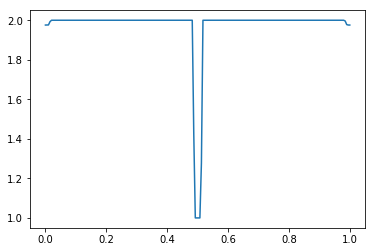

In [97]:
plt.plot(phase,phase_curve)
# plt.ylim(.999,1.1)

# Experimenting with direct integration of double sigmoid

In [5]:
longitude = np.linspace(-180, 180, 200)
latitude = np.linspace(-90, 90, 100)
latitude_model = np.sin(latitude * np.pi / 180.)
lmax = 3
map = starry.Map(lmax)
map[0, 0] = 1.0

ls

<img src="integrated_double_digmoid_3param.png">

In [137]:
def int_double_sigmoid(alpha=1., beta=0.01, gamma=50, longitude=None, base=0):
    if longitude is None: np.linspace(-180,180,200)
    # longitude = longitude*np.pi/180
    ratio = alpha / beta
    posterm = np.log(np.exp(-beta*(longitude-gamma))+1)
    negterm = np.log(np.exp(-beta*(longitude+gamma))+1)
    return ratio*(posterm + negterm) + base

In [18]:
import numpy as np

In [36]:
def simple_double_sigmoid(params, longitude): 
    amplitude, scale, shift = params
    
    sigmoid_one = 1/(1+np.exp(-scale*(longitude+shift)))
    sigmoid_two = 1/(1+np.exp(-scale*(longitude-shift)))
    
    return amplitude*(sigmoid_one - sigmoid_two)

def double_sigmoid(params, longitude):
    amplitude, scale1, scale2, shift1, shift2 = params

    sigmoid_one = 1/(1+np.exp(-scale1*(longitude+shift1)))
    sigmoid_two = 1/(1+np.exp(-scale2*(longitude-shift2)))
    
    return amplitude*(sigmoid_one - sigmoid_two)

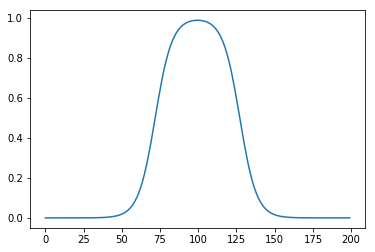

In [40]:
plt.plot(simple_double_sigmoid([1.0, 0.1, 50], longitude))

In [149]:
def int_double_sigmoid(alpha=1., beta=0.01, gamma=50, longitude=None, base=0):
    if longitude is None: longitude = np.linspace(-180,180,200)
    # longitude = longitude*np.pi/180
    ratio = alpha / beta
    posterm = np.log(np.exp(-beta*(longitude-gamma))+1)
    negterm = np.log(np.exp(-beta*(longitude+gamma))+1)
    return ratio*(posterm + negterm) + base

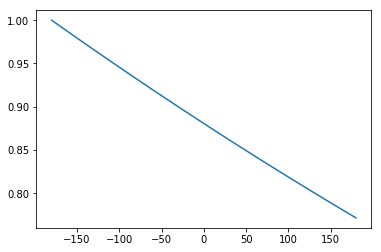

In [157]:
pcurve = int_double_sigmoid(1.0, 0.001, 50)
plt.plot(np.linspace(-180,180,200), pcurve/pcurve.max());

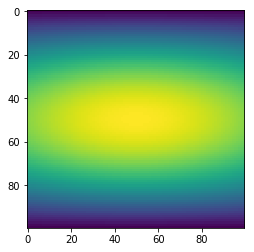

In [117]:
image = np.zeros((100,100))

latitudes, longitudes = np.indices((100,100))
latitudes = (latitudes - latitudes.min()) / (latitudes.max() - latitudes.min())*2-1.0
latitudes = latitudes*90
longitudes = (longitudes - longitudes.min()) / (longitudes.max() - longitudes.min())*2-1.0
longitudes = longitudes*180

long_pattern = simple_double_sigmoid([1.0, 0.005, 50], longitudes)
lat_pattern = 1*np.cos(latitudes * np.pi / 180.)+0.0

plt.imshow(lat_pattern*long_pattern);

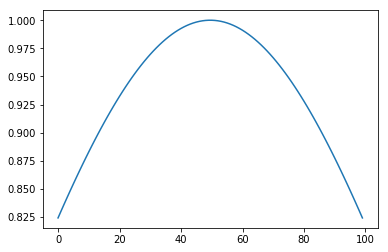

In [118]:
pcurve = np.sum(lat_pattern*long_pattern,axis=0)
plt.plot(pcurve/pcurve.max())